# ** Rules **

**Required Reading/Viewing:**
1. [Learning to See [Part 1]](https://www.youtube.com/watch?v=i8D90DkCLhI)

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

## So what are we like, doing?

In this module, we're focused on a single problem, counting the number of fingers in images from a [Leap Motion](https://www.leapmotion.com/) Infared Camera. 

![](../videos/finger_counting_demo.gif)

---

## Data!

In [1]:
%pylab inline
import pickle
import sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load data:
with open('../data/training_data.p', 'rb') as f:
    data = pickle.load(f)

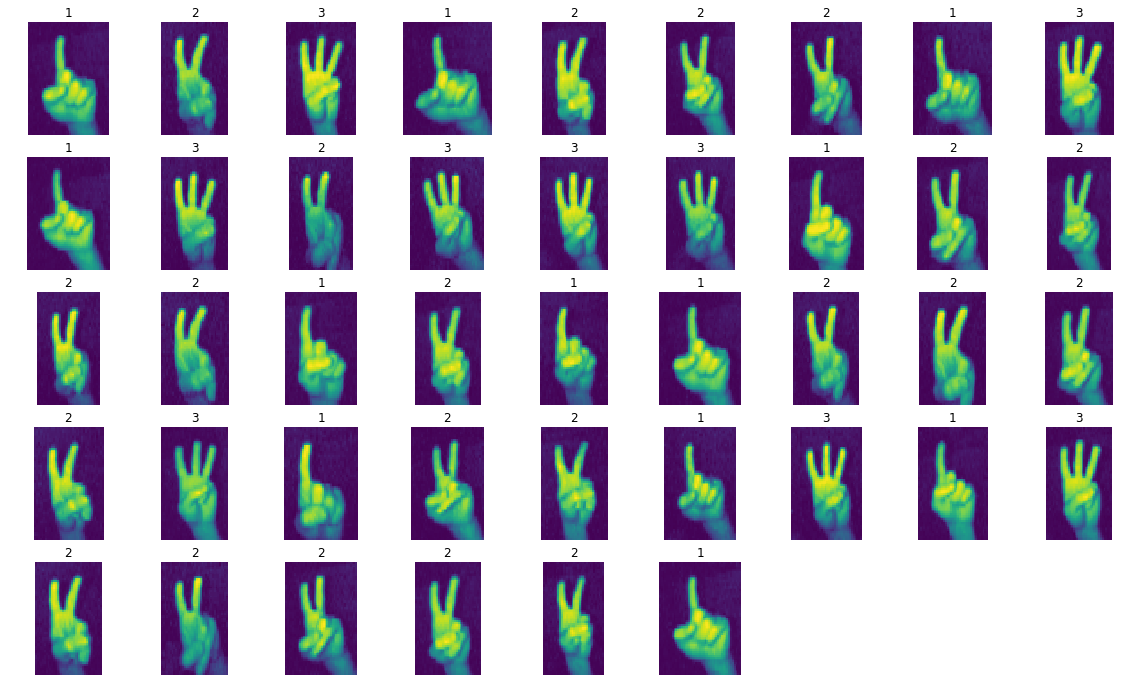

In [3]:
fig = figure(0, (20, 12))

for i in range(len(data)):
    fig.add_subplot(5, 9, i+1)
    
    cropped_image = data[i]['image'][data[i]['boxEdges'][2]:data[i]['boxEdges'][3], \
                                       data[i]['boxEdges'][0]:data[i]['boxEdges'][1]] 
    
    imshow(cropped_image)
    title(str(data[i]['numFingers']))
    axis('off')

In [4]:
len(data)

42

42 images on hands. 

![](../graphics/spacer_small.png)

# So, how do we write an algorithm to count fingers?

Let's start by making our problem a little simpler by downsampling to our images to binary:

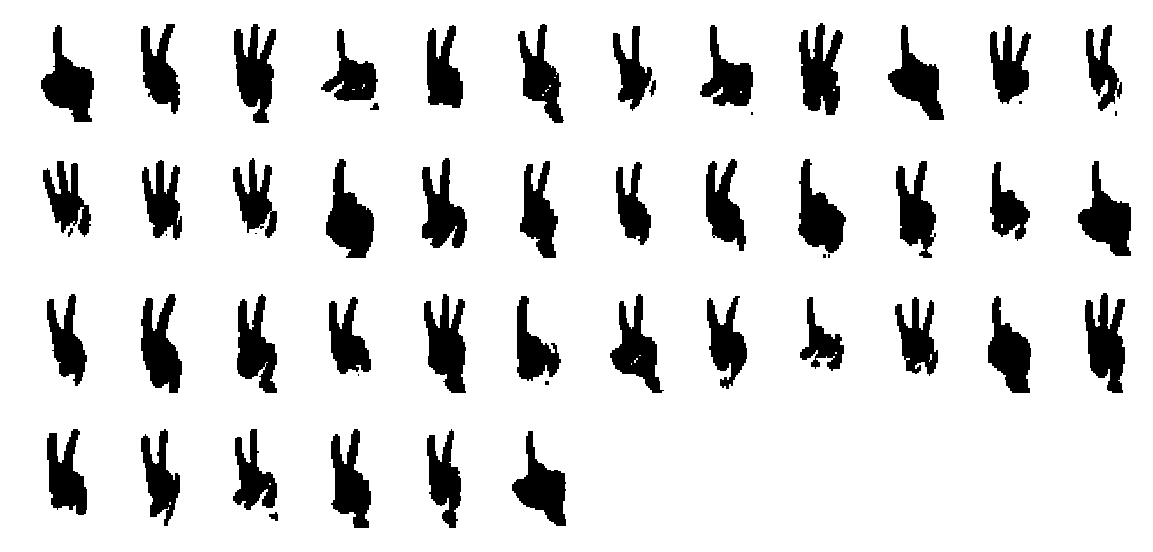

In [5]:
fig = figure(0, (20,12))
for i in range(len(data)):
    subplot(5,12,i+1)
    imshow(data[i]['image1bit'][data[i]['boxEdges'][2]:data[i]['boxEdges'][3], \
                                       data[i]['boxEdges'][0]:data[i]['boxEdges'][1]], cmap = 'Greys')
    axis('off')

![](../graphics/spacer_small.png)

## **We would like to know which pixels belong to fingers**

- For each pixel, we don't need to consider the entire image to decide if it belongs to a finger, so we'll sample a 9x9 grid around each pixel to simplify our problem.

![](../graphics/samplingGrids.png)

In [6]:
#Let's pick a few examples to experiment with:
exampleIndices = [0, 1, 2]

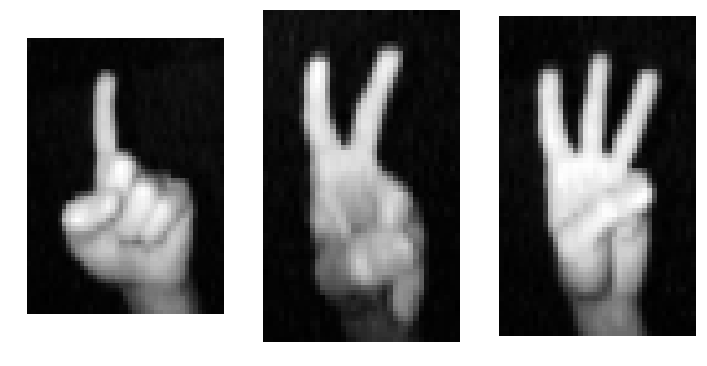

In [7]:
fig = figure(0, (12,8))

for i, exampleIndex in enumerate(exampleIndices):
    subplot(1,3,i+1)
    imshow(data[exampleIndex]['croppedImage'], cmap = 'gray', interpolation = 'none')
    axis('off')

Extract 9x9 grids from these examples.

In [8]:
sys.path.append('../util')
from data_handling import extractExamplesFromList

examples = [data[index] for index in exampleIndices]
X, y = extractExamplesFromList(examples, whichImage = 'image1bit', dist = 4)

In [9]:
print(X.shape, y.shape)

(7867, 81) (7867,)


Let's have a look at one of our examples:

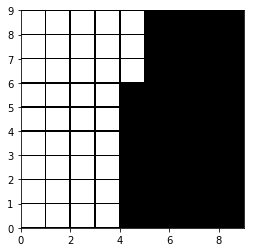

In [11]:
exampleToShow = X[600,:].reshape(9,9)

fig = figure(0, (4, 4))
pcolor(flipud(exampleToShow), cmap = 'Greys',  linewidth =.5, color = 'k', vmin = 0, vmax = 1)

In [12]:
#And as numbers:
print(exampleToShow.astype('int'))

[[0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1]]


## **Now, Let's try to create some rules that desribe what fingers look like.**

Here's one simple rule. I claim that fingers should look like this:

In [13]:
rule1 = np.array(([[0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 1, 1, 1, 1, 1, 0, 0]])) 

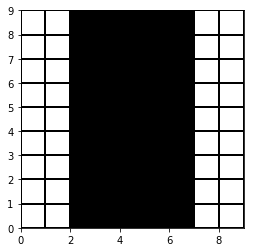

In [14]:
figure(0, (4,4))
pcolor(flipud(rule1), cmap = 'Greys',  linewidth =1, \
       color = 'k', vmin = 0, vmax = 1)

Search for matches to our new rule in our data:

In [15]:
difference = X-rule1.ravel()
np.where(~difference.any(axis=1))[0]

array([ 737,  782,  827,  872, 3415, 3453, 3491, 5957, 5997])

Found some matches! Let's visualize these suckers. We'll have to do this going through images ones at a time:

In [16]:
from viz import showMatches

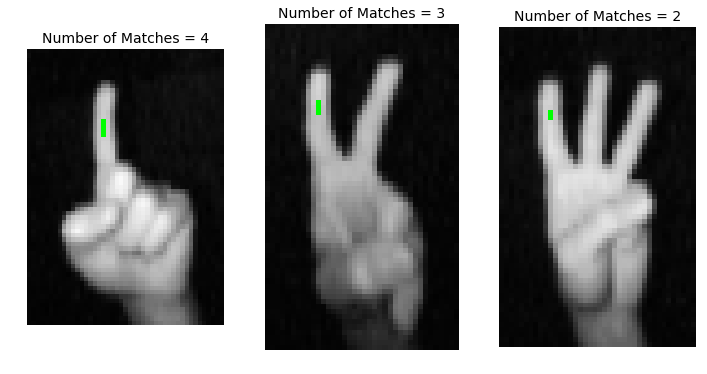

In [17]:
fig = figure(0, (12, 6))
showMatches(rules = [rule1], exampleIndices = exampleIndices, \
            data=data, fig=fig)

## In Class Exercise 1 - make your own rules
- Partner up, let's take 5 minutes, make your own rules and see if you can get more matches.

![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

---

One possible time-saving approach here is to create a larger finger pattern, and shift it around:

In [18]:
ruleToSample = np.array(([[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], 
                          [ 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]]))

In [19]:
rules = []
for i in range(6):
    for j in range(5):
        rules.append(ruleToSample[i:i+9, j:j+9])

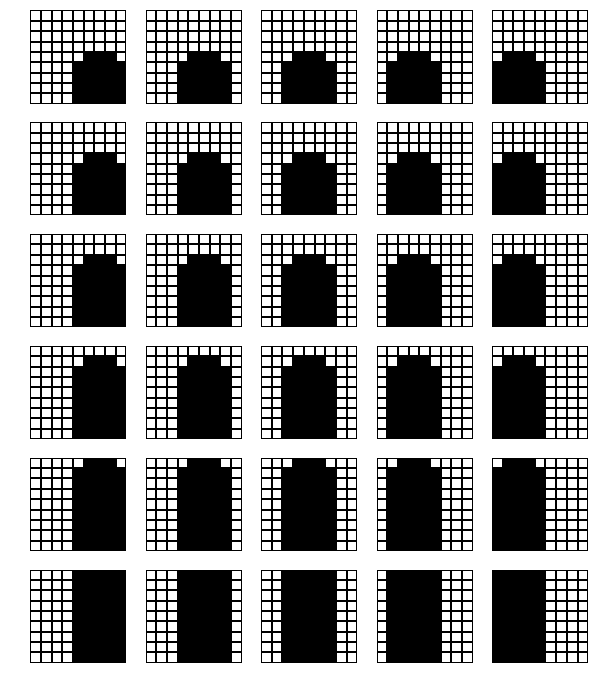

In [20]:
fig = figure(0, (10,12))
for i, rule in enumerate(rules):
    subplot(6,5,i+1)
    p = pcolor(flipud(rule), cmap = 'Greys',  linewidth =1, \
                  color = 'k', vmin = 0, vmax = 1)
    axis('off')

In [21]:
len(rules)

30

We now have 30 rules, let's try them out!!!

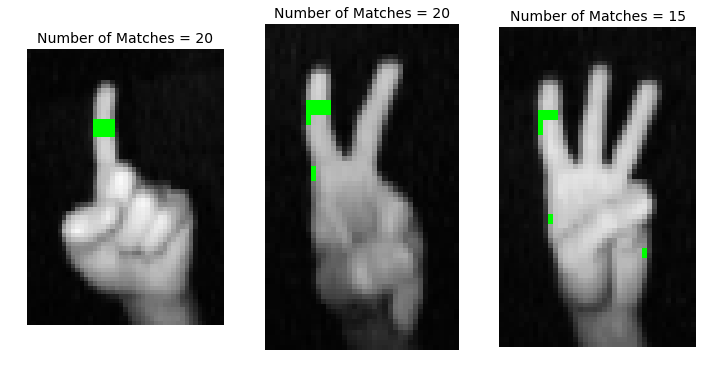

In [22]:
fig = figure(0, (12, 6))
showMatches(rules = rules, exampleIndices = exampleIndices, \
            data=data, fig=fig)

So, this looks better, but definitely not perfect. Also, we're getting a couple different types of errors. 

---

![](../graphics/spacer_small.png)

## ** How are we doing? **
- Let's quanitify our performance
- Notice that there are 2 different ways in which out algorithm could be wrong!
- Confusion matrices are going to be super important going foward, so make sure you're comfortable with them.
- Let's talk a little about the tradeoffs between false positives and false negatives. 

![](../graphics/confusion_matrix_intro.png)

### Finger labels from Leap Motion software
- These aren't perfect, but we'll assume they're close enough and let these labels be our "ground truth".

In [23]:
from data_handling import extractFeatures
from image import makeGrayScale

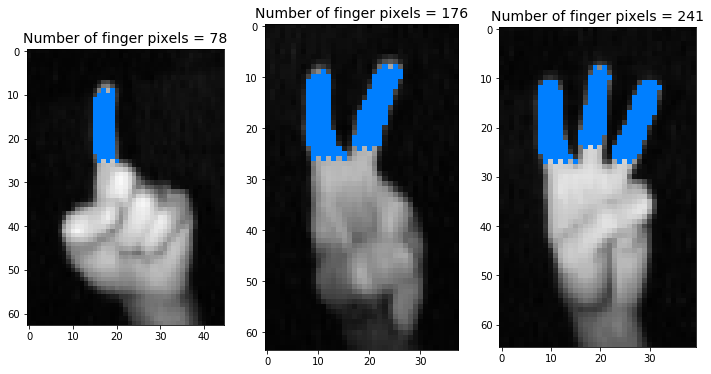

In [24]:
fig = figure(0, (12, 6))

for i in range(3):
    fig.add_subplot(1,3,i+1)
    imageDict = data[exampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    im = makeGrayScale(imageDict)
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im)
    title('Number of finger pixels = ' + str(sum(y1==1)), fontsize = 14)

## Compute Confusion Matrix

In [25]:
# Search for matches to rules
matchingIndices = np.array([], dtype = 'int')
for rule in rules:
    difference = X - rule.ravel()
    mI = np.where(~difference.any(axis=1))[0]
    matchingIndices = np.concatenate((matchingIndices, mI))

# Make yHat vector, tells us which 
# pixels our rules predict to be fingers.
yHat = np.zeros(X.shape[0])
yHat[matchingIndices] = 1

# Count up False Negatives, False Positives, 
# True Positives, and True Negatives
FN =  np.sum(np.logical_and(y==1, yHat==0))
FP =  np.sum(np.logical_and(y==0, yHat==1))
TP = np.sum(np.logical_and(y==1, yHat==1))
TN = np.sum(np.logical_and(y==0, yHat==0))
    
# Make confusion matrix:
confusionMatrix = np.array([[TP, FN], [FP, TN]])

print(confusionMatrix)

[[  48  447]
 [   7 7365]]


## In Class Exercise 2 - Make Your Own **Better** Rules
- Now, working in your desk clumps, based on everything you've learned so far, see if you can improve performance. 
- The goal here is to reduce false positives and false negatives. 
- Work with you group for 10 minutes, then put your confusion matrix results and a little bit strategy on the whiteboard.
- Choose one representative from your team to present your results and explain your strategy.